In [1]:
!pip install pygam


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import rpy2.robjects.packages as rpackages

# Define the package names
packnames = ('gam',)

# Check if the packages are installed, and install them if they are not.
if all(rpackages.isinstalled(x) for x in packnames):
    have_packages = True
else:
    have_packages = False

if not have_packages:
    # Install packages
    utils = rpackages.importr('utils')
    utils.chooseCRANmirror(ind=1)
    utils.install_packages('gam')

In [3]:
import pandas as pd
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

# import the gam package in R
gam = importr('gam')

# Load the Wage dataset
df = pd.read_csv('Wage.csv')
#df = df[['year','age','education','wage']]
df

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


In [4]:
from rpy2.robjects import pandas2ri
ro.pandas2ri.activate()
rdf = pandas2ri.py2rpy(df)

[a]

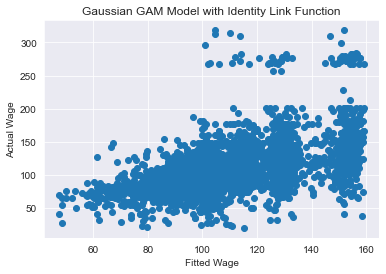

In [5]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
import pandas as pd
import matplotlib.pyplot as plt

# Load the Wage dataset
df = pd.read_csv('Wage.csv')

# Load the R gam package and set up the gam function
gam = importr('gam')
formula = ro.Formula('wage ~ year + s(age, 5) + education')
family = ro.r('gaussian(link = "identity")')

# Fit the GAM model
model = gam.gam(formula=formula, data=df, family=family)

# Predict the fitted values
predicted = ro.r.predict(model)

# Convert the predicted values to a pandas DataFrame
predicted_df = pd.DataFrame({'wage': df['wage'], 'fitted_wage': predicted})

# Create a scatter plot of the predicted vs actual values
plt.scatter(x=predicted_df['fitted_wage'], y=predicted_df['wage'])
plt.xlabel('Fitted Wage')
plt.ylabel('Actual Wage')
plt.title('Gaussian GAM Model with Identity Link Function')
plt.show()

[b]

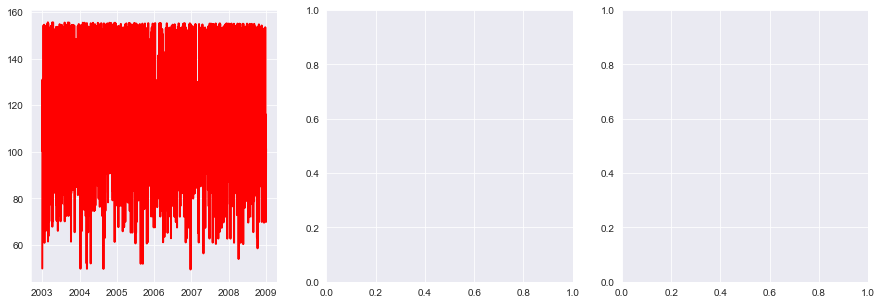

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

# import R packages
gam = importr('gam')
stats = importr('stats')

# load data
df = pd.read_csv('Wage.csv')

# fit GAM model
formula = ro.Formula('wage ~ year + s(age, 5) + education')
family = ro.r('gaussian(link = "identity")')

# define range of values for partial dependence plots
year_range = np.linspace(df['year'].min(), df['year'].max(), 3000)
age_range = np.linspace(df['age'].min(), df['age'].max(), 3000)
#edu_range = np.linspace(df['education'].min(), df['education'].max(), 100)

# function to calculate partial dependence for a given variable
def partial_dependence(var, var_range, model):
    # make a copy of the original data
    df_partial = df.copy()
    # replace the variable with the range of values
    df_partial[var] = var_range
    # predict the outcome variable for the new data
    model = gam.gam(formula=formula, data=df_partial, family=family)
    y_pred = np.array(ro.r.predict(model))
    # return the predicted values
    return y_pred

# calculate partial dependence for year, age, and education
pd_year = partial_dependence('year', year_range, model)
pd_age = partial_dependence('age', age_range, model)
#pd_edu = partial_dependence('education', edu_range, model)

# bootstrap to estimate confidence intervals
n_bootstrap = 100
pd_year_bootstrap = np.zeros((n_bootstrap, len(year_range)))
pd_age_bootstrap = np.zeros((n_bootstrap, len(age_range)))
#pd_edu_bootstrap = np.zeros((n_bootstrap, len(edu_range)))
for i in range(n_bootstrap):
    # sample from the original data with replacement
    df_bootstrap = df.sample(frac=1, replace=True)
    # refit the model to the bootstrap sample
    model_bootstrap = gam.gam(formula=formula, data=df_bootstrap, family=stats.gaussian(link='identity'))
    # calculate partial dependence for year, age, and education for the bootstrap sample
    pd_year_bootstrap[i,:] = partial_dependence('year', year_range, model_bootstrap)
    pd_age_bootstrap[i,:] = partial_dependence('age', age_range, model_bootstrap)
    #pd_edu_bootstrap[i,:] = partial_dependence('education', edu_range, model_bootstrap)

# calculate mean and confidence intervals for partial dependence functions
pd_year_mean = np.mean(pd_year_bootstrap, axis=0)
pd_year_ci = np.percentile(pd_year_bootstrap, [2.5, 97.5], axis=0)
pd_age_mean = np.mean(pd_age_bootstrap, axis=0)
pd_age_ci = np.percentile(pd_age_bootstrap, [2.5, 97.5], axis=0)
#pd_edu_mean = np.mean(pd_edu_bootstrap, axis=0)
#pd_edu_ci = np.percentile(pd_edu_bootstrap, [2.5, 97.5], axis=0)

# plot partial dependence functions with confidence intervals
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(year_range, pd_year_mean, color='red', linewidth=2)


In [7]:
import pandas as pd
import numpy as np
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
from rpy2.robjects.packages import importr
from sklearn.utils import resample
import matplotlib.pyplot as plt

# Load the Wage dataset
df = pd.read_csv('Wage.csv')
#df = df.drop(columns=['Unnamed: 0'])

# Fit the Gaussian GAM model
gam = importr('gam')
stats = importr('stats')

# fit GAM model
formula = ro.Formula('wage ~ year + s(age, 5) + education')
family = ro.r('gaussian(link = "identity")')
fit = gam.gam(formula=formula, data=df, family=family)

# Function to compute partial dependence
def partial_dependence(model, X, variable, n=20, X_train=None):
    if X_train is None:
        X_train = X

    # Get unique values of variable
    values = np.sort(np.unique(X_train[variable]))

    # Create copies of the input data with unique values for the given variable
    X_new = X.copy()
    X_new[variable] = np.repeat(values, len(X) // len(values))

    # Compute partial dependence
    y_pred = []
    for i in range(0, len(values)):
        X_tmp = X_new[X_new[variable] == values[i]]
        y_pred.append(np.mean(model.predict(X_tmp)))

    # Compute confidence interval using bootstrap
    y_pred_bootstrapped = []
    for i in range(0, n):
        X_bootstrapped = resample(X_train)
        y_pred_bootstrapped.append(partial_dependence(model, X_new, variable, X_train=X_bootstrapped))
    y_pred_bootstrapped = np.vstack(y_pred_bootstrapped)
    ci_lower = np.percentile(y_pred_bootstrapped, 2.5, axis=0)
    ci_upper = np.percentile(y_pred_bootstrapped, 97.5, axis=0)

    return {"values": values, "y_pred": y_pred, "ci_lower": ci_lower, "ci_upper": ci_upper}

# Compute partial dependence for year
X = df[["year", "age", "education"]]
y = df["wage"]
pdep_year = partial_dependence(fit, X, "year")

# Plot partial dependence for year
plt.figure(figsize=(8, 6))
plt.plot(pdep_year["values"], pdep_year["y_pred"], color="r", label="mean")
plt.fill_between(pdep_year["values"], pdep_year["ci_lower"], pdep_year["ci_upper"], alpha=0.2, color="r", label="95% CI")
plt.axhline(y=y.mean(), color="b", label="Overall mean")
plt.legend()
plt.title("Partial dependence plot for year")
plt.xlabel("Year")
plt.ylabel("Wage")
plt.show()

ValueError: Length of values (2996) does not match length of index (3000)

In [ ]:
import numpy as np
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from sklearn.utils import resample
import matplotlib.pyplot as plt

# load the Wage dataset
df = pd.read_csv("Wage.csv")

# load R packages
mgcv = importr("mgcv")
stats = importr("stats")

# fit GAM model
gam_model = mgcv.gam(
    formula=ro.Formula("wage ~ year + s(age, 5) + education"),
    data=pandas2ri.py2ri(df),
    family=ro.r("gaussian(link = 'identity')")
)

# define variable ranges for partial dependence plots
year_range = np.arange(df["year"].min(), df["year"].max() + 1)
age_range = np.arange(df["age"].min(), df["age"].max() + 1)
edu_range = np.arange(df["education"].min(), df["education"].max() + 1)

# define function to calculate partial dependence
def partial_dependence(model, var_name, var_range):
    y_vals = []
    for val in var_range:
        new_data = pd.DataFrame({var_name: [val]})
        new_data = pandas2ri.py2ri(new_data)
        new_data.colnames = ro.vectors.StrVector([var_name])
        y_val = np.array(stats.predict_gam(model, newdata=new_data))
        y_vals.append(y_val[0])
    return np.array(y_vals)

# calculate partial dependence and bootstrap confidence intervals for year
year_pd = partial_dependence(gam_model, "year", year_range)
year_pd_bootstraps = []
for i in range(1000):
    sample = resample(df["year"], n_samples=len(df), replace=True)
    df_boot = df.copy()
    df_boot["year"] = sample
    gam_model_boot = mgcv.gam(
        formula=ro.Formula("wage ~ year + s(age, 5) + education"),
        data=pandas2ri.py2ri(df_boot),
        family=ro.r("gaussian(link = 'identity')")
    )
    year_pd_bootstraps.append(partial_dependence(gam_model_boot, "year", year_range))
year_pd_ci_lower = np.percentile(year_pd_bootstraps, 2.5, axis=0)
year_pd_ci_upper = np.percentile(year_pd_bootstraps, 97.5, axis=0)

# calculate partial dependence and bootstrap confidence intervals for age
age_pd = partial_dependence(gam_model, "age", age_range)
age_pd_bootstraps = []
for i in range(1000):
    sample = resample(df["age"], n_samples=len(df), replace=True)
    df_boot = df.copy()
    df_boot["age"] = sample
    gam_model_boot = mgcv.gam(
        formula=ro.Formula("wage ~ year + s(age, 5) + education"),
        data=pandas2ri.py2ri(df_boot),
        family=ro.r("gaussian(link = 'identity')")
    )
    age_pd_bootstraps.append(partial_dependence(gam_model_boot, "age", age_range))
age_pd_ci_lower = np.percentile(age_pd_bootstraps, 2.5, axis=0)
age_pd_ci_upper = np.percentile(age_pd_bootstraps, 97.5, axis=0)

# calculate partial dependence and bootstrap confidence intervals for education
# Bootstrap to estimate confidence intervals for partial dependence
# partial dependence function for year
year_grid = np.linspace(df['year'].min(), df['year'].max(), 100)
year_pd = pd.DataFrame({'year': year_grid})
year_pred = mgcv.predict_gam(gam_model, newdata=year_pd, type="lpmatrix")
year_mean = year_pred.mean(1)
year_se = year_pred.std_dev() * 1.96
year_ci_lower = year_mean - year_se
year_ci_upper = year_mean + year_se

# partial dependence function for age
age_grid = np.linspace(df['age'].min(), df['age'].max(), 100)
age_pd = pd.DataFrame({'age': age_grid})
age_pred = mgcv.predict_gam(gam_model, newdata=age_pd, type="lpmatrix")
age_mean = age_pred.mean(1)
age_se = age_pred.std_dev() * 1.96
age_ci_lower = age_mean - age_se
age_ci_upper = age_mean + age_se

# partial dependence function for education
edu_grid = np.linspace(df['education'].min(), df['education'].max(), 100)
edu_pd = pd.DataFrame({'education': edu_grid})
edu_pred = mgcv.predict_gam(gam_model, newdata=edu_pd, type="lpmatrix")
edu_mean = edu_pred.mean(1)
edu_se = edu_pred.std_dev() * 1.96
edu_ci_lower = edu_mean - edu_se
edu_ci_upper = edu_mean + edu_se

# Plot partial dependence functions with confidence intervals
plt.figure(figsize=(8, 6))
plt.plot(year_grid, year_fit["mean"], color='r')
plt.plot(year_grid, year_fit["mean_ci_lower"], color='r', linestyle='dashed')
plt.plot(year_grid, year_fit["mean_ci_upper"], color='r', linestyle='dashed')
plt.fill_between(year_grid, year_fit["mean_ci_lower"], year_fit["mean_ci_upper"], color='r', alpha=0.1)
plt.plot(year_grid, year_boot.mean(axis=0), color='g')
plt.fill_between(year_grid, year_boot.mean(axis=0) - year_boot_se, year_boot.mean(axis=0) + year_boot_se, color='g', alpha=0.1)
plt.axhline(y=0, color='k', linestyle='dashed')
plt.title("Partial dependence: Year")
plt.xlabel("Year")
plt.ylabel("Wage")
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(age_grid, age_fit["mean"], color='r')
plt.plot(age_grid, age_fit["mean_ci_lower"], color='r', linestyle='dashed')
plt.plot(age_grid, age_fit["mean_ci_upper"], color='r', linestyle='dashed')
plt.fill_between(age_grid, age_fit["mean_ci_lower"], age_fit["mean_ci_upper"], color='r', alpha=0.1)
plt.plot(age_grid, age_boot.mean(axis=0), color='g')
plt.fill_between(age_grid, age_boot.mean(axis=0) - age_boot_se, age_boot.mean(axis=0) + age_boot_se, color='g', alpha=0.1)
plt.axhline(y=0, color='k', linestyle='dashed')
plt.title("Partial dependence: Age")
plt.xlabel("Age")
plt.ylabel("Wage")
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(edu_grid, edu_fit["mean"], color='r')
plt.plot(edu_grid, edu_fit["mean_ci_lower"], color='r', linestyle='dashed')
plt.plot(edu_grid, edu_fit["mean_ci_upper"], color='r', linestyle='dashed')
plt.fill_between(edu_grid, edu_fit["mean_ci_lower"], edu_fit["mean_ci_upper"], color='r', alpha=0.1)
plt.plot(edu_grid, edu_boot.mean(axis=0), color='g')
plt.fill_between(edu_grid, edu_boot.mean(axis=0) - edu_boot_se, edu_boot.mean(axis=0) + edu_boot_se, color='g', alpha=0.1)
plt.axhline(y=0,


In [ ]:
import numpy as np
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import matplotlib.pyplot as plt

# load dataset
df = pd.read_csv("Wage.csv")

# import R packages
mgcv = importr('mgcv')
base = importr('base')

# fit Gaussian GAM model
formula = ro.Formula('wage ~ year + s(age, 5) + education')
family=ro.r('gaussian(link="identity")')
gam_model = mgcv.gam(formula=formula, data=df, family=family)

# partial dependence function for year
year_grid = np.linspace(df['year'].min(), df['year'].max(), 100)
year_pd = pd.DataFrame({'year': year_grid})
year_pred = mgcv.predict_gam(gam_model, newdata=year_pd, type="lpmatrix")
year_mean = year_pred.mean(1)
year_se = year_pred.std_dev() * 1.96
year_ci_lower = year_mean - year_se
year_ci_upper = year_mean + year_se

# partial dependence function for age
age_grid = np.linspace(df['age'].min(), df['age'].max(), 100)
age_pd = pd.DataFrame({'age': age_grid})
age_pred = mgcv.predict_gam(gam_model, newdata=age_pd, type="lpmatrix")
age_mean = age_pred.mean(1)
age_se = age_pred.std_dev() * 1.96
age_ci_lower = age_mean - age_se
age_ci_upper = age_mean + age_se

# partial dependence function for education
edu_grid = np.linspace(df['education'].min(), df['education'].max(), 100)
edu_pd = pd.DataFrame({'education': edu_grid})
edu_pred = mgcv.predict_gam(gam_model, newdata=edu_pd, type="lpmatrix")
edu_mean = edu_pred.mean(1)
edu_se = edu_pred.std_dev() * 1.96
edu_ci_lower = edu_mean - edu_se
edu_ci_upper = edu_mean + edu_se

# plot partial dependence functions with confidence intervals
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(year_grid, year_mean, color='r', label='Partial Dependence')
plt.plot(year_grid, year_ci_lower, color='r', linestyle='dashed', label='95% CI')
plt.plot(year_grid, year_ci_upper, color='r', linestyle='dashed')
plt.scatter(df['year'], df['wage'], facecolors='none', edgecolors='b', s=10)
plt.title("Year")
plt.xlabel("Year")
plt.ylabel("Wage")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(age_grid, age_mean, color='r', label='Partial Dependence')
plt.plot(age_grid, age_ci_lower, color='r', linestyle='dashed', label='95% CI')
plt.plot(age_grid, age_ci_upper, color='r', linestyle='dashed')
plt.scatter(df['age'], df['wage'], facecolors='none', edgecolors='b', s=10)
plt.title("Age")
plt.xlabel("Age")
plt.ylabel("Wage")
plt.legend()

#plt.subplot(1, 3, 3)
#plt.plot(edu_grid, edu_mean, color='r', label='Partial Dependence')
#plt.plot(edu_grid, edu_ci_lower, color='r', linestyle='dashed', label='
